Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель: Построить модель для определения стоимости автомобиля. Найти золотую середину между скоростью обучения,предсказания и качеством предсказаний.**

# Подготовка данных<a class="anchor" id="start"></a>

In [ ]:
# Загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle
import lightgbm
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor
import time
import warnings
warnings.filterwarnings('ignore')
notebook = time.time()

In [ ]:
# Ознакомимся с данными
df = pd.read_csv("/datasets/autos.csv")
pd.set_option('display.max_columns', None)
# Привели к нижнему регистру
df.columns = df.columns.str.lower()
display(df.head())
display(df.info())
df.nunique()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
datecrawled          354369 non-null object
price                354369 non-null int64
vehicletype          316879 non-null object
registrationyear     354369 non-null int64
gearbox              334536 non-null object
power                354369 non-null int64
model                334664 non-null object
kilometer            354369 non-null int64
registrationmonth    354369 non-null int64
fueltype             321474 non-null object
brand                354369 non-null object
notrepaired          283215 non-null object
datecreated          354369 non-null object
numberofpictures     354369 non-null int64
postalcode           354369 non-null int64
lastseen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


None

datecrawled          271174
price                  3731
vehicletype               8
registrationyear        151
gearbox                   2
power                   712
model                   250
kilometer                13
registrationmonth        13
fueltype                  7
brand                    40
notrepaired               2
datecreated             109
numberofpictures          1
postalcode             8143
lastseen             179150
dtype: int64

**Вывод**
- Всего 16 Признаков, в т.ч. целевой `price`, некоторые признаки: `datecrawled`, `registrationmonth`, `datecreated`, `numberofpictures`, `postalcode`, `lastseen` скорее всего не окажут влияние на предсказание модели (имеют 0 корреляцию с `price`), их нужно будет удалить перед обучением;
- Есть пропуски в признаках и скорее всего 0 значения, необходимо провести предобработку.

## Препроцессинг<a class="anchor" id="pr"></a>

In [ ]:
# Определим Nan в каждом признаке и сделаем вывод
features = df.columns.to_list()
for k in features:
    print(k)
    display(df[df[k].isna()])

datecrawled


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


price


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


vehicletype


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354346,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38
354351,2016-03-11 23:40:32,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-03-11 00:00:00,0,87700,2016-03-12 14:16:51
354361,2016-03-09 13:37:43,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09 00:00:00,0,51371,2016-03-13 01:44:13
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49


registrationyear


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


gearbox


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354288,2016-03-16 13:36:25,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,2016-03-16 00:00:00,0,12057,2016-03-17 12:17:07
354305,2016-04-03 13:46:24,3500,NaN,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03 00:00:00,0,74579,2016-04-05 12:44:38
354329,2016-03-30 20:55:30,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30 00:00:00,0,25436,2016-04-07 13:50:41
354338,2016-03-31 19:52:33,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04


power


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


model


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
81,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03 00:00:00,0,45665,2016-04-05 11:47:13
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27 00:00:00,0,38709,2016-04-05 20:17:31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354245,2016-03-07 16:37:42,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,yes,2016-03-07 00:00:00,0,55743,2016-03-12 21:45:25
354321,2016-03-15 13:52:34,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes,2016-03-15 00:00:00,0,91186,2016-03-17 08:16:25
354338,2016-03-31 19:52:33,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04
354351,2016-03-11 23:40:32,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-03-11 00:00:00,0,87700,2016-03-12 14:16:51


kilometer


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


registrationmonth


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


fueltype


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
13,2016-03-21 21:37:40,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,no,2016-03-21 00:00:00,0,90762,2016-03-23 02:50:54
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
36,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11 00:00:00,0,2943,2016-04-07 03:46:09
41,2016-03-30 20:38:20,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,NaN,2016-03-30 00:00:00,0,33649,2016-04-03 11:44:49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354339,2016-03-20 12:46:00,3850,convertible,2006,manual,108,2_reihe,125000,2,NaN,peugeot,no,2016-03-20 00:00:00,0,53947,2016-03-26 21:18:23
354346,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38
354351,2016-03-11 23:40:32,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-03-11 00:00:00,0,87700,2016-03-12 14:16:51
354361,2016-03-09 13:37:43,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09 00:00:00,0,51371,2016-03-13 01:44:13


brand


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


notrepaired


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
12,2016-03-15 22:49:09,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN,2016-03-15 00:00:00,0,37269,2016-04-01 13:16:16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354349,2016-03-16 17:06:19,5999,wagon,2005,manual,140,a4,150000,4,gasoline,audi,NaN,2016-03-16 00:00:00,0,56472,2016-03-18 11:30:17
354356,2016-04-04 11:45:16,999,convertible,2000,manual,95,megane,150000,4,petrol,renault,NaN,2016-04-04 00:00:00,0,88477,2016-04-06 12:44:52
354357,2016-03-09 11:36:55,1690,wagon,2004,manual,55,fabia,150000,4,petrol,skoda,NaN,2016-03-09 00:00:00,0,18246,2016-04-04 08:15:30
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52


datecreated


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


numberofpictures


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


postalcode


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


lastseen


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


In [ ]:
# Посмотрим как отличаются машины одой модели и бренда
display(df[(df['model'] == 'golf') & (df['gearbox'] == 'auto')])
display(df[(df['model'] == 'golf') & (df['gearbox'] == 'manual')])

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
190,2016-03-08 21:52:34,11299,sedan,2006,auto,250,golf,150000,8,petrol,volkswagen,no,2016-03-08 00:00:00,0,22083,2016-03-19 09:46:58
245,2016-03-30 20:42:52,14700,sedan,2012,auto,211,golf,60000,12,petrol,volkswagen,yes,2016-03-30 00:00:00,0,42283,2016-04-07 12:45:20
386,2016-03-27 14:51:02,5600,bus,2008,auto,140,golf,150000,7,gasoline,volkswagen,no,2016-03-27 00:00:00,0,42281,2016-04-07 11:45:06
387,2016-03-07 07:55:46,10550,sedan,2012,auto,105,golf,60000,10,petrol,volkswagen,no,2016-03-07 00:00:00,0,44309,2016-03-22 01:18:19
438,2016-03-26 17:39:51,13499,wagon,2010,auto,160,golf,60000,4,petrol,volkswagen,no,2016-03-26 00:00:00,0,4107,2016-04-06 06:16:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353911,2016-03-26 15:52:57,10950,sedan,2010,auto,105,golf,125000,4,gasoline,volkswagen,no,2016-03-26 00:00:00,0,45661,2016-04-06 04:15:47
354019,2016-03-26 07:53:56,1599,small,1996,auto,90,golf,150000,9,petrol,volkswagen,no,2016-03-26 00:00:00,0,31582,2016-04-05 18:46:58
354020,2016-03-21 13:37:12,690,sedan,1991,auto,90,golf,125000,2,petrol,volkswagen,no,2016-03-21 00:00:00,0,79235,2016-03-29 22:15:37
354164,2016-03-27 13:53:33,11990,bus,2009,auto,122,golf,30000,5,petrol,volkswagen,no,2016-03-27 00:00:00,0,54585,2016-04-07 09:46:24


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
35,2016-03-08 07:54:46,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08 00:00:00,0,19386,2016-03-08 09:44:50
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25 00:00:00,0,48499,2016-03-31 21:47:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354315,2016-03-29 13:53:42,1300,convertible,1998,manual,90,golf,150000,4,petrol,volkswagen,no,2016-03-29 00:00:00,0,38518,2016-03-31 07:15:48
354320,2016-03-19 19:39:53,1500,sedan,1999,manual,75,golf,150000,4,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,37339,2016-04-07 07:15:21
354348,2016-03-20 18:47:59,5900,sedan,2006,manual,105,golf,150000,9,gasoline,volkswagen,no,2016-03-20 00:00:00,0,1217,2016-04-07 02:44:27
354359,2016-03-28 13:48:07,7900,sedan,2010,manual,140,golf,150000,7,gasoline,volkswagen,no,2016-03-28 00:00:00,0,75223,2016-04-02 18:16:20


**Выводы**
- Обнаружены NaN в признаках `vehiletype`, `gearbox`, `model`, `fueltype`, `notrepaired`;
- Так как пропуски в категориальных признаках, то их заполнение может приводить к ошибкам и к переобучению;
- Удаление пропусков приведет к уменьшению выборки в два раза, этого допустить нельзя;
- Если посмотреть на модель WV Golf, то мы видим, что одна и таже модель различается по типу кузова, по году, и в зависимости от комплектации - мощность, коробка. Также существенный вклад в цену вносит наличие ремонта. Можем попробовать заполнить тип топлива, т.к. топливо в основном бензин, остальные признаки отдать на совесть OHE, catboost'у и lgbm они закодируют пропуски цифрами;
- Пропуски в модели можем заменить на other, т.к. есть такое значение в этом признаке, а гадать какой автомобиль перед нами LADA Каен или Порше Vesta мы не можем:) Также как был в ремонте или нет.
- Также видим, что данные не совсем корректны, особенно ценник есть машины, 2017 года стоят 7750, а есть и за 350 Евро (Где это объявление? Дайте два golfa, я 700 евро подготовлю), хотя пробег одинаковый;
- Также нужно gasoline перевести в petrol, т.к. это все обозначение бензина в Англии и США, соответственно.

In [ ]:
# Создадим функцию для определения 0 и 'None'
def null(k):
    element = [0, 'None']
    k = k
    for i in element:
        display(df[df[k] == i])

In [ ]:
for k in features:
    print(k)
    null(k)

datecrawled


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


price


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09 00:00:00,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


vehicletype


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


registrationyear


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


gearbox


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


power


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354338,2016-03-31 19:52:33,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04
354346,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


model


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


kilometer


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


registrationmonth


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
36,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11 00:00:00,0,2943,2016-04-07 03:46:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354305,2016-04-03 13:46:24,3500,NaN,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03 00:00:00,0,74579,2016-04-05 12:44:38
354318,2016-03-15 19:57:11,400,wagon,1991,manual,0,legacy,150000,0,petrol,subaru,NaN,2016-03-15 00:00:00,0,24558,2016-03-19 15:49:00
354326,2016-03-31 19:36:18,1300,small,1999,manual,75,2_reihe,125000,0,NaN,peugeot,NaN,2016-03-31 00:00:00,0,35102,2016-04-06 13:44:44
354329,2016-03-30 20:55:30,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30 00:00:00,0,25436,2016-04-07 13:50:41


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


fueltype


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


brand


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


notrepaired


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


datecreated


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


numberofpictures


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


postalcode


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


lastseen


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


**Вывод**
- Нулевые значения обнаружены в целевом признаке `price`, необходимо провести исследование, посмотреть на boxplot и определить аномальные значения цены, после этого удалить;
- Обнаружены 0 значения в `power` - мощность можно заполнить по модели и году регистрации;
- Месяц регистрации - скорее всего просто незаполненные данные, данный признак будет проверен на корреляцию с ценой и скорее всего удален.

In [ ]:
# Удалим признаки, которые не оказывают влияние на цену
df = df.drop(['datecrawled', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen'], axis=1)

In [ ]:
# Поменяем NaN в моделях на 'other'
df['model'] = df['model'].replace(np.nan, "other")

In [ ]:
# Заполним пропуски в типе топлива по брэнду и модели
mapper = df.groupby(["brand","model"])['fueltype'].first().to_dict()

def fuel(row):
    if pd.isnull(row['fueltype']):
        return mapper.get((row['brand'],row['model']))
    return row['fueltype']

df['fueltype'] = df.apply(fuel, axis=1)

In [ ]:
# Проверка
df[df['fueltype'].isna()]

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired


In [ ]:
# Обработаем 0 значения в 'power'
df['power'] = df['power'].replace(0, np.nan)
mapper = df.groupby(['brand','model', 'registrationyear'])['power'].mean().to_dict()

def power(row):
    if pd.isnull(row['power']):
        return mapper.get((row['brand'], row['model'], row['registrationyear']))
    return row['power']

df['power'] = df.apply(power, axis=1)

In [ ]:
# Проверка
# df[df['power'].isna()]
# Остались единичные экземпляры

In [ ]:
# Добьем пропуски
mapper = df.groupby(["model", 'brand'])['power'].mean().to_dict()

def power1(row):
    if pd.isnull(row['power']):
        return mapper.get((row['model'], row['brand']))
    return row['power']

df['power'] = df.apply(power1, axis=1)

**Проверка дубликатов**

In [ ]:
# Проверим признаки по уникальным значениям
features_1 = df.columns.to_list()
for k in features_1:
    print(k)
    display(df[k].value_counts())

price


0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13440        1
1414         1
8069         1
10370        1
384          1
Name: price, Length: 3731, dtype: int64

vehicletype


sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicletype, dtype: int64

registrationyear


2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
3200        1
1920        1
1919        1
1915        1
8455        1
Name: registrationyear, Length: 151, dtype: int64

gearbox


manual    268251
auto       66285
Name: gearbox, dtype: int64

power


75.000000       24052
60.000000       15924
150.000000      14608
101.000000      13313
140.000000      12873
                ...  
15016.000000        1
696.000000          1
155.333333          1
89.222222           1
1339.000000         1
Name: power, Length: 4113, dtype: int64

model


other                 44126
golf                  29232
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 250, dtype: int64

kilometer


150000    238209
125000     36454
100000     14882
90000      11567
80000      10047
70000       8593
60000       7444
5000        6397
50000       6232
40000       4911
30000       4436
20000       3975
10000       1222
Name: kilometer, dtype: int64

registrationmonth


0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: registrationmonth, dtype: int64

fueltype


petrol      239077
gasoline    108631
lpg           5556
cng            565
hybrid         233
other          217
electric        90
Name: fueltype, dtype: int64

brand


volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: brand, dtype: int64

notrepaired


no     247161
yes     36054
Name: notrepaired, dtype: int64

- gasoline сменить на petrol, cng и lpg - газ, но разный;
- других дубликатов в катфичах не найдено;
- Года регистрации с ошибками, есть 4100 год, мощность тоже подозрительная, необходимо  проверить в исследовании данных.

In [ ]:
df['fueltype'] = df['fueltype'].replace('gasoline', 'petrol')
df['fueltype'].value_counts()
# Нефтянная игла на лицо

petrol      347708
lpg           5556
cng            565
hybrid         233
other          217
electric        90
Name: fueltype, dtype: int64

In [ ]:
df[df.duplicated(subset=df.columns.to_list())].sort_values(by='model', ascending=False)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
354363,1150,bus,2000,manual,112.133929,zafira,150000,3,petrol,opel,no
267929,2650,bus,2004,manual,147.000000,zafira,150000,10,petrol,opel,no
245275,2500,bus,2001,NaN,129.505000,zafira,150000,0,petrol,opel,no
63705,2600,wagon,2005,NaN,129.045775,zafira,150000,6,petrol,opel,NaN
246553,2600,wagon,2005,NaN,129.045775,zafira,150000,0,petrol,opel,NaN
...,...,...,...,...,...,...,...,...,...,...,...
218716,2990,sedan,1990,manual,136.000000,100,150000,1,lpg,audi,no
239381,2150,sedan,1988,manual,136.000000,100,150000,4,petrol,audi,no
290663,6450,wagon,1992,manual,230.000000,100,150000,4,petrol,audi,no
283561,2400,wagon,1993,manual,133.000000,100,150000,3,petrol,audi,no


In [ ]:
# проверим, действительно ли есть дубликаты
# df.query('model == "zafira" & power == 165')

In [ ]:
# удалим дубликаты.
df = df.drop_duplicates().reset_index(drop=True)

In [ ]:
down = (354369 - len(df)) / 354369 * 100
print('Уменьшение полной выборки на {:.2f} %'.format(down))

Уменьшение полной выборки на 8.19 %


## Исследование признаков<a id="research"></a>

In [ ]:
df_before = df.loc[:, ['price', 'registrationyear', 'power', 'kilometer', 'registrationmonth']]

In [ ]:
# Проверим статистические данные и возможные аномалии
df.describe()

,price,registrationyear,power,kilometer,registrationmonth
count,325338.000000,325338.000000,325336.000000,325338.000000,325338.000000
mean,4410.673835,2004.236775,123.217124,128110.565012,5.701431
std,4520.588801,91.326364,193.416596,37964.744958,3.721754
min,0.000000,1000.000000,1.000000,5000.000000,0.000000
25%,1000.000000,1999.000000,75.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,110.000000,150000.000000,6.000000
75%,6390.000000,2008.000000,147.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


**Вывод**
- `price` - много 0 значений, а также аномально высоких, медиана и средняя сильно различаются, среднеквадратическое отклонение выше среднего, нужно проверить цены как снижу, так и сверху и удалить аномальные значения, чтобы приблизить среднее к медиане.
- `registrationyear` - с аномалиями - 9999 год и 1000 год, необходимо просмотреть данные выше 2019 года, и ниже 1950 (послевоеннное), различные раритеты будем относить к аномалиям. Средняя и медиана близки, а вот ср.кв.отклонение, практически век;
- `power` - мощность важный показатель при определении стоимости, есть аномалии, драгстэры (20 кило л.с.) и повозки с лошадкой (1 л.с.), ср.кв.отклоение больше среднего.

### Price

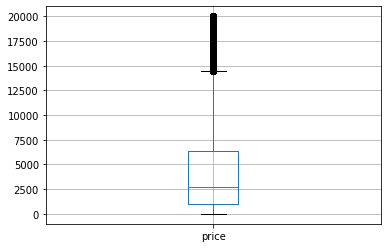

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6a26141d90>]],
      dtype=object)

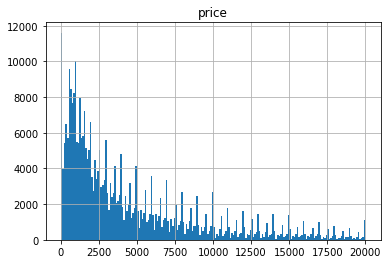

In [ ]:
# Начнем исследование цены
df.loc[:, ['price']].boxplot()
plt.show()
df.loc[:, ['price']].hist(bins=200)

Удалим цены до 200 евро и выше 17500, посмотрим % снижения выборки и новое распределение

In [ ]:
thresh = 200
df.drop(df[df['price'] <= thresh].index, inplace=True)
display(df.shape)
down = (354369 - len(df)) / 354369 * 100
print('Уменьшение полной выборки на {:.2f} %'.format(down))

(307917, 11)

Уменьшение полной выборки на 13.11 %


In [ ]:
thresh = 17500
df.drop(df[df['price'] >= thresh].index, inplace=True)
display(df.shape)
down = (354369 - len(df)) / 354369 * 100
print('Уменьшение полной выборки на {:.2f} %'.format(down))

(301383, 11)

Уменьшение полной выборки на 14.95 %


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6a8c4b9c90>]],
      dtype=object)

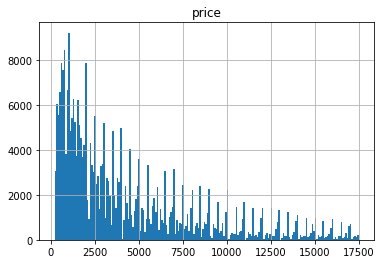

In [ ]:
df.loc[:, ['price']].hist(bins=200)
# Распределение нормальное

### Registrationyear

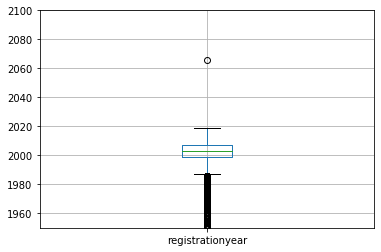

In [ ]:
# Исследуем год регистрации
df.loc[:, ['registrationyear']].boxplot()
plt.ylim(1950, 2100)
plt.show()

In [ ]:
df.query('registrationyear <= 1987').sort_values(by ='registrationyear', ascending=False)
# Выбросы до 1987 (мало данных), а выше 2020 не может быть:)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
167656,6600,sedan,1987,auto,132.000000,e_klasse,150000,8,petrol,mercedes_benz,no
175243,600,sedan,1987,manual,72.000000,golf,125000,5,petrol,volkswagen,yes
178545,10000,coupe,1987,manual,110.000000,other,50000,5,petrol,opel,no
178543,1500,wagon,1987,manual,50.000000,transporter,150000,5,petrol,volkswagen,no
177976,5700,sedan,1987,auto,152.000000,other,125000,7,petrol,ford,no
...,...,...,...,...,...,...,...,...,...,...,...
229145,2000,NaN,1000,NaN,517.000000,other,5000,0,petrol,sonstige_autos,NaN
69832,500,NaN,1000,NaN,733.333333,golf,5000,0,petrol,volkswagen,NaN
89319,400,NaN,1000,NaN,517.000000,other,5000,0,petrol,sonstige_autos,NaN
228766,2500,NaN,1000,NaN,34.000000,other,5000,0,petrol,sonstige_autos,NaN


In [ ]:
df.drop(df[df['registrationyear'] <= 1987].index, inplace=True)
df.drop(df[df['registrationyear'] >= 2020].index, inplace=True)
down = (354369 - len(df)) / 354369 * 100
print('Уменьшение полной выборки на {:.2f} %'.format(down))

Уменьшение полной выборки на 16.66 %


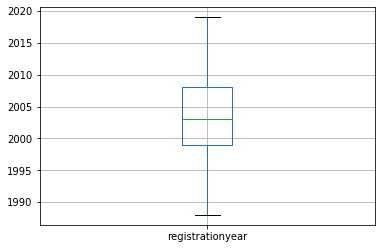

In [ ]:
# Проверим распределение
df.loc[:, ['registrationyear']].boxplot()
plt.show()
# Расспределение то что надо:)

### Power

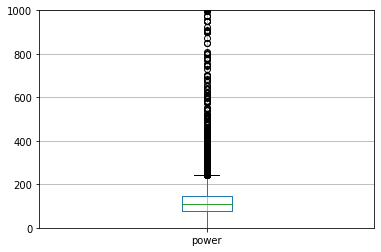

In [ ]:
# Исследуем мощность
df.loc[:, ['power']].boxplot()
plt.ylim(0, 1000)
plt.show()

In [ ]:
df.query('power >= 300').sort_values(by ='power', ascending=False)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
207334,4300,coupe,1999,auto,20000.0,clk,150000,1,petrol,mercedes_benz,no
277671,1500,wagon,1997,manual,19312.0,5er,150000,1,petrol,bmw,no
110284,9999,sedan,2006,manual,19211.0,1er,125000,0,petrol,bmw,NaN
127536,2100,wagon,2001,manual,19208.0,5er,150000,5,petrol,bmw,yes
62649,3250,sedan,2001,auto,17932.0,omega,150000,6,petrol,opel,NaN
...,...,...,...,...,...,...,...,...,...,...,...
305173,4290,wagon,1999,manual,300.0,a6,150000,7,petrol,audi,no
14637,15500,convertible,2006,manual,300.0,other,60000,7,petrol,nissan,no
80914,16500,convertible,2006,manual,300.0,other,40000,4,petrol,nissan,no
14235,5000,wagon,1999,auto,300.0,a6,150000,8,petrol,audi,no


In [ ]:
# Такие выбросы нужно удалять
df.query('power <= 40').sort_values(by ='power', ascending=False)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
282222,333,small,1998,manual,40.0,other,80000,3,petrol,fiat,no
79039,680,small,1998,manual,40.0,seicento,150000,12,petrol,fiat,NaN
214218,700,small,1997,manual,40.0,corsa,150000,12,petrol,opel,no
77112,450,small,1995,manual,40.0,other,60000,5,petrol,fiat,NaN
76666,400,small,1998,manual,40.0,other,5000,6,petrol,hyundai,NaN
...,...,...,...,...,...,...,...,...,...,...,...
69997,6000,other,2009,manual,1.0,other,5000,1,other,sonstige_autos,no
130472,799,sedan,1997,manual,1.0,megane,150000,4,petrol,renault,NaN
32776,3900,convertible,2004,auto,1.0,forfour,90000,5,petrol,smart,no
288671,600,NaN,2000,auto,1.0,other,150000,4,petrol,volkswagen,no


In [ ]:
# Оставим работать более правдоподобный интервал
df.drop(df[df['power'] <= 40].index, inplace=True)
df.drop(df[df['power'] >= 300].index, inplace=True)
display(df.shape)

(291465, 11)

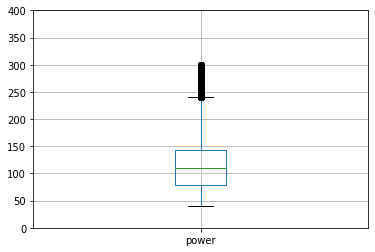

In [ ]:
# Проверка распределения
df.loc[:, ['power']].boxplot()
plt.ylim(0, 400)
plt.show()

### Графики распределений после обработки

In [ ]:
df_after = df.loc[:, ['price', 'registrationyear', 'power', 'kilometer', 'registrationmonth']]

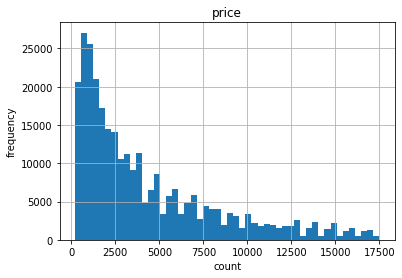

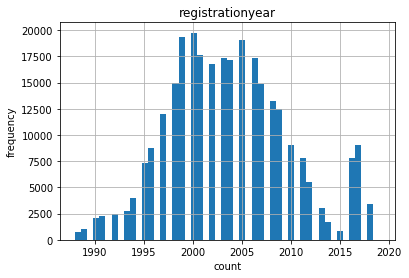

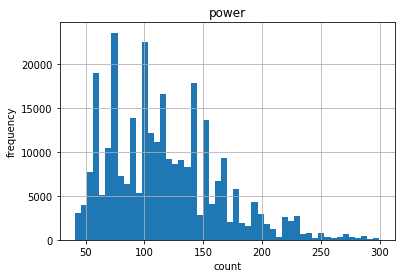

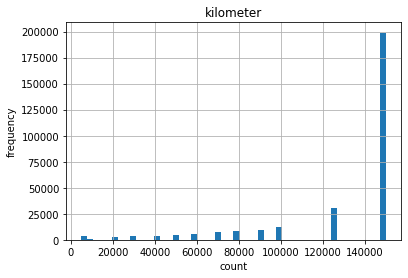

In [ ]:
# Посмотрим на нормальные распределения после всей обработки и чистки 
def show_me_hist(df, i):
    df[df.columns.values[i]].hist(bins=50)
    plt.xlabel('count')
    plt.ylabel('frequency')
    plt.title(df.columns.values[i])
    plt.show()
for i in range(4):
    show_me_hist(df_after, i)

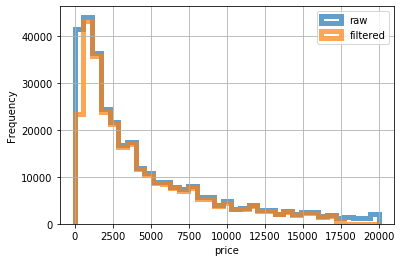

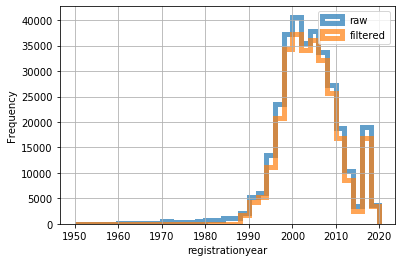

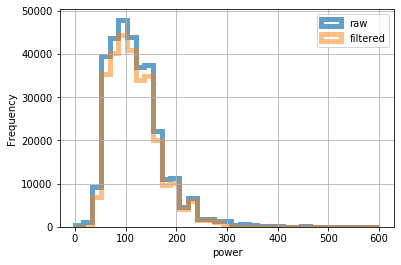

In [ ]:
# Сравним расспределение до и после обработки
ax = df_before.plot(kind='hist', y='price', histtype='step', range=(0, 20000), bins=35, linewidth=5, alpha=0.7, label='raw')
df_after.plot(kind='hist', y='price', histtype='step', range=(0, 20000), bins=35, linewidth=5, alpha=0.7, label='filtered', ax=ax, grid=True, legend=True)
plt.xlabel('price')
plt.show()
ax = df_before.plot(kind='hist', y='registrationyear', histtype='step', range=(1950, 2020), bins=35, linewidth=5, alpha=0.7, label='raw')
df_after.plot(kind='hist', y='registrationyear', histtype='step', range=(1950, 2020), bins=35, linewidth=5, alpha=0.7, label='filtered', ax=ax, grid=True, legend=True)
plt.xlabel('registrationyear')
plt.show()
ax = df_before.plot(kind='hist', y='power', histtype='step', range=(0, 600), bins=35, linewidth=5, alpha=0.7, label='raw')
df_after.plot(kind='hist', y='power', histtype='step', range=(0, 600), bins=35, linewidth=5, alpha=0.5, label='filtered', ax=ax, grid=True, legend=True)
plt.xlabel('power')
plt.show()

### Корреляция

In [ ]:
# Проверим корреляцию до и после исследования
df_before.corr()

,price,registrationyear,power,kilometer,registrationmonth
price,1.000000,0.026335,0.127500,-0.329592,0.107158
registrationyear,0.026335,1.000000,0.003887,-0.053222,-0.011739
power,0.127500,0.003887,1.000000,0.021825,0.012112
kilometer,-0.329592,-0.053222,0.021825,1.000000,0.010085
registrationmonth,0.107158,-0.011739,0.012112,0.010085,1.000000


In [ ]:
df_after.corr()

,price,registrationyear,power,kilometer,registrationmonth
price,1.000000,0.477687,0.473502,-0.351873,0.088871
registrationyear,0.477687,1.000000,0.069307,-0.296716,0.009331
power,0.473502,0.069307,1.000000,0.126609,0.039146
kilometer,-0.351873,-0.296716,0.126609,1.000000,-0.011376
registrationmonth,0.088871,0.009331,0.039146,-0.011376,1.000000


**Вывод**
- Исследование и чистка помогли настроить правильную корреляцию цены от года регистрации, мощности. Изначально из-за выбросов и аномальных данных, такой зависимости не было;
- Месяц регистрации не коррелирует с ценой - удалить

In [ ]:
df = df.drop(['registrationmonth'], axis=1)

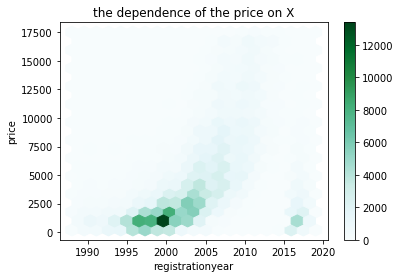

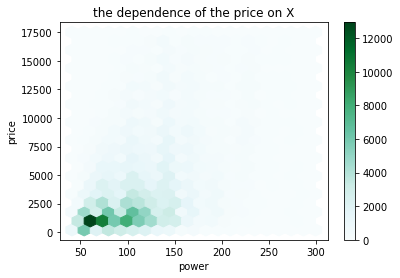

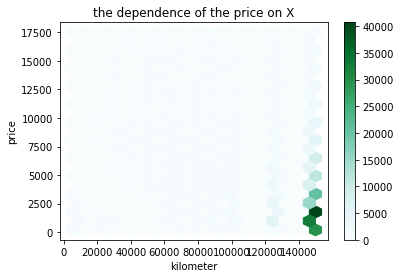

In [ ]:
# Проверим зависимость цены от числовых признаков признаков
def show_me_skatter(df, i):
    df.plot(x=df.columns.values[i+1], y=df.columns.values[0], kind='hexbin', gridsize=20, sharex=False)
    plt.title('the dependence of the price on X')
    plt.show()
for i in range(3):
    show_me_skatter(df_after, i)

In [ ]:
df.describe()
# Год регистрации и мощность теперь в норме, с ценой ситуация улучшилась, но не намного

,price,registrationyear,power,kilometer
count,291465.00000,291465.000000,291465.000000,291465.000000
mean,4286.02742,2003.671556,117.318457,129832.947352
std,4011.58207,6.210332,46.773602,35817.569524
min,202.00000,1988.000000,41.000000,5000.000000
25%,1200.00000,1999.000000,78.000000,125000.000000
50%,2800.00000,2003.000000,110.000000,150000.000000
75%,6200.00000,2008.000000,143.000000,150000.000000
max,17499.00000,2019.000000,299.701493,150000.000000


**Выводы**
- Исследовательский анализ помог нам выявить основную зависимость числовых признаков от цены;
- Были нормализованы распределения признаков и снижены std до приемлемых значений, путем выявления и удаления выбросов и аномалий.

# Обучение моделей

## Подготовка признаков для машинного обучения

In [ ]:
# Подготовим признаки для четырех моделей:
# LinearRegression, RandomForestRegressor, Catboost, LGBM
# Выделим числовые и категориальные признаки
numeric_f = ['registrationyear', 'power', 'kilometer']
cat_features = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']
# Предподготовленый датасет
df.shape

(291465, 10)

In [ ]:
# Сделаем датасеты для каждой модели
df_l = df.copy()
df_cat = df.copy()
df_lgbm = df.copy()
# Подготовим типы данных для catboost & LGBM
for i in cat_features:
    df_cat[i] = df_cat[i].astype(str)
# LGBM
for i in cat_features:
    df_lgbm[i] = df_lgbm[i].astype('category')   

In [ ]:
# Препроцессинг для LR & RF
# OHE
df_l = pd.get_dummies(df_l, drop_first=True)
X = df_l.drop(['price'], axis = 1)
y = df_l['price']
# Разделим выборки, тестировать будем на train+valid
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
# Проведем масштабирование признаков
scaler = StandardScaler()
scaler.fit(X_tr[numeric_f])
X_tr[numeric_f] = scaler.transform(X_tr[numeric_f])
X_val[numeric_f] = scaler.transform(X_val[numeric_f])
display(X_tr.head()) # проверим
if (X_tr.shape[0] + X_val.shape[0]) == len(df):
    print("Проверка пройдена")

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_evoque,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_2,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fueltype_electric,fueltype_hybrid,fueltype_lpg,fueltype_other,fueltype_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_yes
302994,1.500603,-0.670315,-2.226530,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Проверка пройдена


In [ ]:
# Создадим функцию для определения RMSE
def rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

## Константная модель

In [ ]:
# Создадим константную модель для определения границы для следующих моделей
target_constant = pd.Series(y_tr.median(), index=y_tr.index)
const = rmse(y_tr, target_constant) # squared=False не работает
print('Результат константной модели RMSE: {:.2f}'.format(const))

Результат константной модели RMSE: 4284.35


## Linear Regression

In [ ]:
# LinearRegression
line = LinearRegression()
lr = time.time()
line.fit(X_tr, y_tr)
lr2 = time.time()
y_pred = line.predict(X_val)
lr3 = time.time()
print('Результат линейной регрессии: {:.2f}'.format(rmse(y_val, y_pred)))
print('Время обучения ЛР: {:.2f} cек.'.format(lr2 - lr))
print('Время предсказания ЛР: {:.2f} cек.'.format(lr3 - lr2))

Результат линейной регрессии: 2327.64
Время обучения ЛР: 24.90 cек.
Время предсказания ЛР: 0.21 cек.


In [ ]:
# Проверка результата на кросс-валидации (линейная регрессия нестабильная)
line_rmse = cross_val_score(line, X_tr, y_tr, cv=3, scoring = make_scorer(rmse, greater_is_better=False))
lr4 = time.time()
print('Лучшее предсказание линейной регрессии: {:.2f}'.format(np.min(line_rmse*-1)))
print('Время затраченное на обучение и предсказание линейной регрессией (кросс-валидация):{:.2f} сек.'.format((lr4-lr3)))

Лучшее предсказание линейной регрессии: 2318.68
Время затраченное на обучение и предсказание линейной регрессией (кросс-валидация):63.49 сек.


## RandomForestRegressor

In [ ]:
# Подберем гиперпараметры для случайного леса
# Random_forest = RandomForestRegressor()
#grid = {'max_depth': range (5, 11, 1) }
#forest_rs = RandomizedSearchCV(Random_forest, n_jobs=6, n_iter=6,
                                 #param_distributions=grid, random_state=42, scoring=make_scorer(rmse, greater_is_better=False))
#forest_rs.fit(X_tr, y_tr)
#print('Best Params: \n', forest_rs.best_params_ )
# Ищем только глубину деревьев, т.к. слишком долго искать n_estimators в 6 итерациях
# Best Params: 
# {'max_depth': 10}

In [ ]:
# Создадим функцию - модель Случайного леса
def forest(features_tr, target_tr, features_v, target_v, depth, est):
    forest = RandomForestRegressor(max_depth=depth, n_estimators=est, random_state=42)
    f = time.time()
    forest.fit(features_tr, target_tr)
    f2 = time.time()
    y_pred = line.predict(features_v)
    f3 = time.time()
    forest_rmse = cross_val_score(forest, features_tr, target_tr, cv=3, scoring = make_scorer(rmse, greater_is_better=False))
    print('Результат RFR: {:.2f}'.format(rmse(target_v, y_pred)))
    print('Время обучения RFR: {:.2f} cек.'.format(f2 - f))
    print('Время предсказания RFR: {:.2f} cек.'.format(f3 - f2))
    f4 = time.time()
    print('Лучшее предсказание RFR: {:.2f}'.format(np.mean(forest_rmse)*-1))
    print('Время затраченное на обучение и предсказание RFR (кросс-валидация):{:.2f} сек.'.format((f4-f3)))

In [ ]:
# Проверка RFR на стандартных настройках
# forest(X_tr, y_tr, X_val, y_val, None, 100)

Результат RFR: 2327.64  
Время обучения RFR: 647.83 cек.  
Время предсказания RFR: 0.07 cек.  
Лучшее предсказание RFR: 1520.01  
Время затраченное на обучение и предсказание RFR (кросс-валидация):1234.01 сек

In [ ]:
# Подставим гиперпараметры, полученные RSCV (depth=10)
# forest(X_tr, y_tr, X_val, y_val, 10, 100)

Результат RFR: 2327.64  
Время обучения RFR: 401.58 cек.  
Время предсказания RFR: 0.18 cек.  
Лучшее предсказание RFR: 1721.49  
Время затраченное на обучение и предсказание RFR (кросс-валидация):688.20 сек.

## Catboost

In [ ]:
# Подготовим выборку для catboost
X_cat = df_cat.drop(['price'], axis = 1)
y_cat = df_cat['price']
X_c_tr, X_c_v, y_c_tr, y_c_v = train_test_split(X_cat, y_cat, test_size=0.25, random_state=42)
# display(X_c_tr.shape, X_c_v.shape, y_c_tr.shape, y_c_v.shape)
display(X_c_tr.head()) # проверим
if (X_c_tr.shape[0] + X_c_v.shape[0]) == len(df):
    print("Проверка пройдена")

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
86889,sedan,2010,manual,140.000000,astra,125000,petrol,opel,no
316798,nan,2018,manual,102.000000,3er,150000,petrol,bmw,no
75544,convertible,1996,manual,150.000000,other,150000,petrol,audi,no
320609,small,2006,manual,64.000000,polo,80000,petrol,volkswagen,no
310961,sedan,2007,nan,124.089552,3_reihe,150000,petrol,peugeot,no


Проверка пройдена


In [ ]:
# Создадим функцию - модель catboost
def cat(features_tr, target_tr, features_v, target_v, it, lr, depth):
    catboost = CatBoostRegressor(iterations=it,
                             learning_rate=lr,
                             depth=depth,
                             eval_metric='RMSE',
                             random_seed = 42)
    f = time.time()
    catboost.fit(features_tr, target_tr, eval_set=(features_v, target_v), cat_features=cat_features, use_best_model=True, verbose=100, early_stopping_rounds=5)
    f2 = time.time()
    y_pred = catboost.predict(features_v)
    f3 = time.time()
    print('Результат catboost: {:.2f}'.format(rmse(target_v, y_pred)))
    print('Время обучения catboost: {:.2f} cек.'.format(f2 - f))
    print('Время предсказания catboost: {:.2f} cек.'.format(f3 - f2))

In [ ]:
# Проверим catboost из коробки
# cat(X_c_tr, y_c_tr, X_c_v, y_c_v, None, None, None)

bestTest = 1493.41  
bestIteration = 999

Результат catboost: 1493.41  
Время обучения catboost: 821.48 cек.  
Время предсказания catboost: 0.83 cек.

In [ ]:
# Проверим catboost (на рандомных гиперпараметрах) - сделал, чтобы тестирование провести, позже. Из функции не смог достать predict.
catboost = CatBoostRegressor(iterations=500,
                             learning_rate=0.25,
                             depth=12,
                             eval_metric='RMSE',
                             random_seed = 42)
f = time.time()
catboost.fit(X_c_tr, y_c_tr, eval_set=(X_c_v, y_c_v), cat_features=cat_features, use_best_model=True, verbose=100, early_stopping_rounds=5)
f2 = time.time()
y_pred = catboost.predict(X_c_v)
f3 = time.time()
print('Результат catboost: {:.2f}'.format(rmse(y_c_v, y_pred)))
print('Время обучения catboost: {:.2f} cек.'.format(f2 - f))
print('Время предсказания catboost: {:.2f} cек.'.format(f3 - f2))

0:	learn: 3278.4894803	test: 3268.9227281	best: 3268.9227281 (0)	total: 2.48s	remaining: 20m 37s
100:	learn: 1319.2471609	test: 1437.8706302	best: 1437.8706302 (100)	total: 3m 50s	remaining: 15m 9s
200:	learn: 1229.4752063	test: 1421.9578112	best: 1421.9578112 (200)	total: 8m	remaining: 11m 55s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 1416.661168
bestIteration = 264

Shrink model to first 265 iterations.
Результат catboost: 1416.66
Время обучения catboost: 660.29 cек.
Время предсказания catboost: 1.08 cек.


## LGBM

In [ ]:
# Подготовим данные для LGBM
X_lg = df_lgbm.drop(['price'], axis = 1)
y_lg = df_lgbm['price']
X_l_tr, X_l_v, y_l_tr, y_l_v = train_test_split(X_lg, y_lg, test_size=0.25, random_state=42)
# display(X_l_tr.shape, X_l_v.shape, y_l_tr.shape, y_l_v.shape)
display(X_l_tr.head()) # проверим
if (X_l_tr.shape[0] + X_l_v.shape[0]) == len(df):
    print("Проверка пройдена")

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
86889,sedan,2010,manual,140.000000,astra,125000,petrol,opel,no
316798,NaN,2018,manual,102.000000,3er,150000,petrol,bmw,no
75544,convertible,1996,manual,150.000000,other,150000,petrol,audi,no
320609,small,2006,manual,64.000000,polo,80000,petrol,volkswagen,no
310961,sedan,2007,NaN,124.089552,3_reihe,150000,petrol,peugeot,no


Проверка пройдена


In [ ]:
# Настроим LGBMRegressor
lgbm = LGBMRegressor(boosting_type='gbdt', max_depth=- 1, learning_rate=0.1, n_estimators=100, random_state=42)
f = time.time()
lgbm.fit(X_l_tr, y_l_tr, eval_set=[(X_l_v, y_l_v)], eval_metric='rmse', categorical_feature=cat_features, early_stopping_rounds=5)
f2 = time.time()
y_pred = lgbm.predict(X_l_v)
f3 = time.time()
print('Результат LGBM: {:.2f}'.format(rmse(y_l_v, y_pred)))
print('Время обучения LGBM: {:.2f} cек.'.format(f2 - f))
print('Время предсказания LGBM: {:.2f} cек.'.format(f3 - f2))

[1]	valid_0's rmse: 3718.15	valid_0's l2: 1.38246e+07
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 3457.89	valid_0's l2: 1.1957e+07
[3]	valid_0's rmse: 3236.58	valid_0's l2: 1.04754e+07
[4]	valid_0's rmse: 3031.5	valid_0's l2: 9.19001e+06
[5]	valid_0's rmse: 2853.31	valid_0's l2: 8.14135e+06
[6]	valid_0's rmse: 2701.95	valid_0's l2: 7.30052e+06
[7]	valid_0's rmse: 2563.25	valid_0's l2: 6.57023e+06
[8]	valid_0's rmse: 2443.58	valid_0's l2: 5.9711e+06
[9]	valid_0's rmse: 2335.8	valid_0's l2: 5.45594e+06
[10]	valid_0's rmse: 2241.73	valid_0's l2: 5.02533e+06
[11]	valid_0's rmse: 2158.56	valid_0's l2: 4.6594e+06
[12]	valid_0's rmse: 2084.75	valid_0's l2: 4.34617e+06
[13]	valid_0's rmse: 2019.95	valid_0's l2: 4.08021e+06
[14]	valid_0's rmse: 1961.53	valid_0's l2: 3.84761e+06
[15]	valid_0's rmse: 1911.46	valid_0's l2: 3.65369e+06
[16]	valid_0's rmse: 1867.66	valid_0's l2: 3.48817e+06
[17]	valid_0's rmse: 1829.68	valid_0's l2: 3.34775e+06
[18]	valid_0's rmse

In [ ]:
# Сменим гиперпараметры LGBMRegressor
lgbm = LGBMRegressor(boosting_type='gbdt', max_depth=12, learning_rate=0.3, n_estimators=120, random_state=42)
f = time.time()
lgbm.fit(X_l_tr, y_l_tr, eval_set=[(X_l_v, y_l_v)], eval_metric='rmse', categorical_feature=cat_features, early_stopping_rounds=5)
f2 = time.time()
y_pred = lgbm.predict(X_l_v)
f3 = time.time()
print('Результат LGBM: {:.2f}'.format(rmse(y_l_v, y_pred)))
print('Время обучения LGBM: {:.2f} cек.'.format(f2 - f))
print('Время предсказания LGBM: {:.2f} cек.'.format(f3 - f2))

[1]	valid_0's rmse: 3184.34	valid_0's l2: 1.014e+07
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 2617.64	valid_0's l2: 6.85206e+06
[3]	valid_0's rmse: 2260.56	valid_0's l2: 5.11012e+06
[4]	valid_0's rmse: 2031.14	valid_0's l2: 4.12554e+06
[5]	valid_0's rmse: 1869.37	valid_0's l2: 3.49455e+06
[6]	valid_0's rmse: 1769.98	valid_0's l2: 3.13284e+06
[7]	valid_0's rmse: 1702.48	valid_0's l2: 2.89843e+06
[8]	valid_0's rmse: 1655.51	valid_0's l2: 2.74071e+06
[9]	valid_0's rmse: 1624.63	valid_0's l2: 2.63942e+06
[10]	valid_0's rmse: 1600.13	valid_0's l2: 2.56043e+06
[11]	valid_0's rmse: 1584.56	valid_0's l2: 2.51083e+06
[12]	valid_0's rmse: 1570.65	valid_0's l2: 2.46695e+06
[13]	valid_0's rmse: 1562.38	valid_0's l2: 2.44103e+06
[14]	valid_0's rmse: 1553.63	valid_0's l2: 2.41378e+06
[15]	valid_0's rmse: 1545.37	valid_0's l2: 2.38817e+06
[16]	valid_0's rmse: 1538	valid_0's l2: 2.36543e+06
[17]	valid_0's rmse: 1532.75	valid_0's l2: 2.34932e+06
[18]	valid_0's rmse

## Тестирование моделей

In [ ]:
# Проведем тестирование лучших и быстрых моделей (модернизированный catboost & lgbm)
# соединим выборки train & valid и перемешаем
X_c_test, y_c_test = pd.concat([X_c_tr, X_c_v]), pd.concat([y_c_tr, y_c_v])
X_c_test, y_c_test = shuffle(X_c_test, y_c_test, random_state=42)
X_l_test, y_l_test = pd.concat([X_l_tr, X_l_v]), pd.concat([y_l_tr, y_l_v])
X_l_test, y_l_test = shuffle(X_l_test, y_l_test, random_state=42)

In [ ]:
# catboost
y_pred = catboost.predict(X_c_test)
print('Результат catboost: {:.2f}'.format(rmse(y_c_test, y_pred)))
# lgbm
y_pred = lgbm.predict(X_l_test)
print('Результат LGBM: {:.2f}'.format(rmse(y_l_test, y_pred)))

Результат catboost: 1290.07
Результат LGBM: 1388.06


- Catboost - WIN!

In [ ]:
notebook2 = time.time()
print('Время выполнения всего ноутбука: {:.2f} сек.'.format(notebook2-notebook))

Время выполнения всего ноутбука: 1804.95 сек.


# Анализ моделей

In [ ]:
# Создадим таблицу для сравнения показателей моделей
table = {'Параметры': ['Результат, RMSE', 'Время обучения, сек.', 'Время предсказания, сек'], 'LinReg': [2318.68, 33.29, 0.18], 'RFR_stand': [1520, 647.83, 0.07], 'RFR_modern': [1721, 401.59, 0.18], 'catboost_stand': [1493.41, 821.48, 0.84], 'catboost_modern': [1416.66, 659, 1.25], 'lgbm_stand': [1467.92, 436, 1.33], 'lgbm_modern': [1442, 454.65, 0.93]}
pivot = pd.DataFrame(data=table)
pivot

,Параметры,LinReg,RFR_stand,RFR_modern,catboost_stand,catboost_modern,lgbm_stand,lgbm_modern
0,"Результат, RMSE",2318.68,1520.00,1721.00,1493.41,1416.66,1467.92,1442.00
1,"Время обучения, сек.",33.29,647.83,401.59,821.48,659.00,436.00,454.65
2,"Время предсказания, сек",0.18,0.07,0.18,0.84,1.25,1.33,0.93


**Вывод**
- Лучший результат показал модернизированный catboost - 1416,66 на валидации и 1290 на тесте, второе место занимает модернизированный lgbm - 1442;
- Скорость обучение, самая быстрая по обучению - это модель Линейной регрессии, но результат RMSE самый худший. Если сравнивать победителей, то быстрее обучается lgbm, в стандартной конфигурации обучение происходит в 2 раза быстрее, а результат лучше. При настройке моделей, время обучения catboost можно сократить за счет learning_rate и раней остановки при детекции переобучения.
- Время предсказания, побеждает RFR_stand, все модели градиентного бустинга приближаются, либо превышают секунду.
- Рекомендация: Заказчику необходимо определиться, что важнее, подождать дополнительные 2 минуты, и получить более точный результат, либо затратить на 2 минуты меньше и получить тоже приемлемый результат, скорость предсказания - практически одинаковая.